In [1]:
DATASET_DIR = "dataset2/train"

In [2]:
import os
os.listdir(DATASET_DIR)

['COVID-19', 'Normal', 'Pneumonia-Viral']

In [3]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

In [4]:
IMG_W = 224
IMG_H = 224
CHANNELS = 3
INIT_LR = 1e-4

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 3
EPOCHS = 20
BATCH_SIZE = 16

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)



train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    #color_mode='grayscale',
    class_mode='categorical')


validation_generator =train_datagen.flow_from_directory(
    DATASET_DIR, 
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    #color_mode='grayscale',
    class_mode='categorical',
    shuffle= True,
    subset='validation')


Found 3777 images belonging to 3 classes.
Found 753 images belonging to 3 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import VGG19

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(3, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

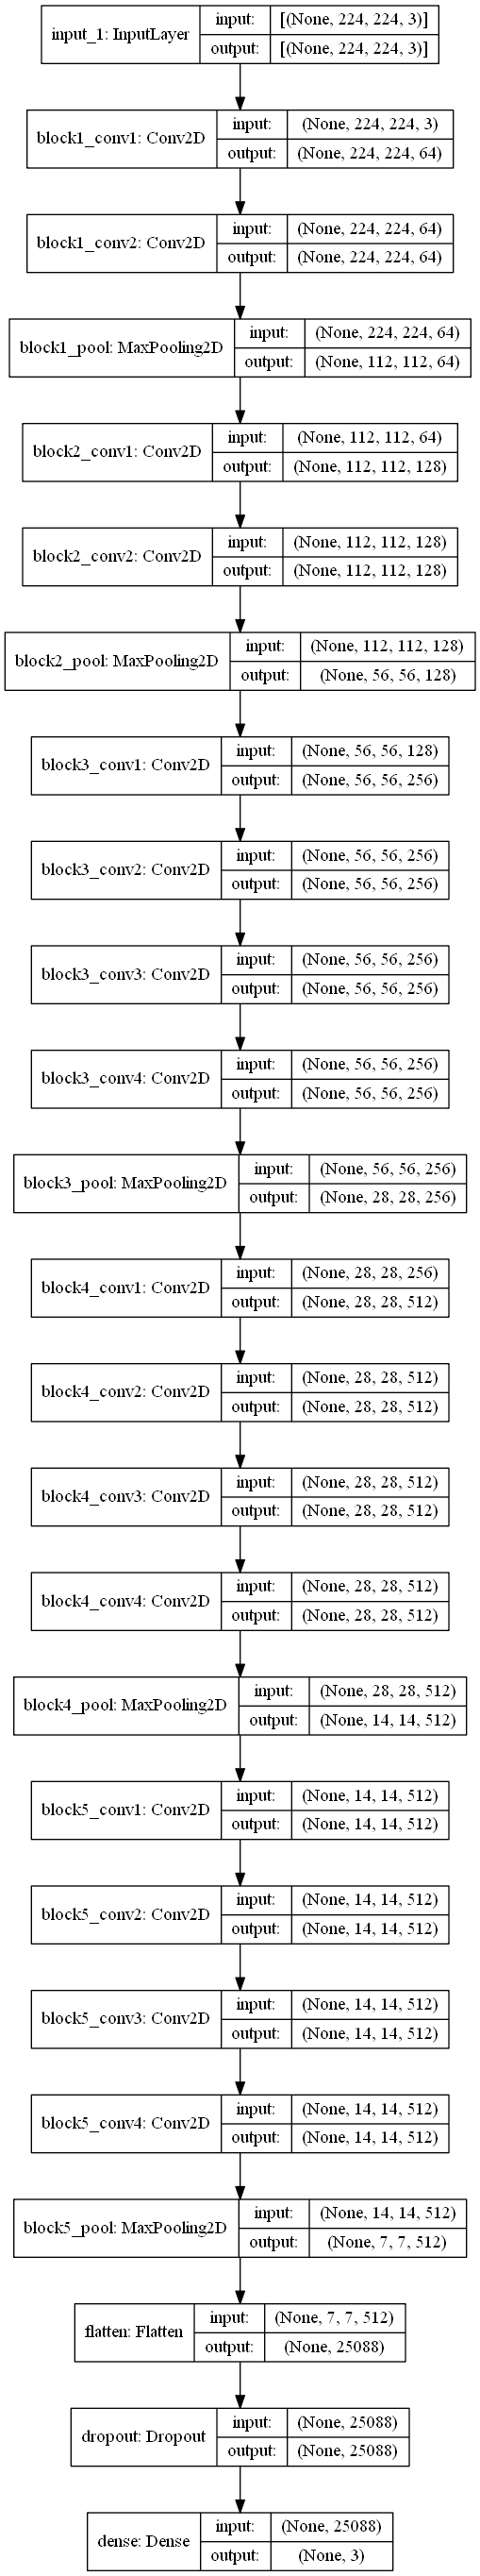

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [9]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
print(len(train_generator))
print(len(validation_generator))

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

237
48


In [11]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [12]:
with tf.device('/gpu:0'):
    result=model.fit_generator(train_generator,steps_per_epoch=STEP_SIZE_TRAIN, validation_data=validation_generator,validation_steps = STEP_SIZE_VALID,epochs=20)
     

C:\Users\Shelby\.conda\envs\tensorflow23python38-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
236/236 [==============================] - 175s 662ms/step - loss: 0.6065 - accuracy: 0.7869 - val_loss: 0.1314 - val_accuracy: 0.9521
Epoch 2/20
236/236 [==============================] - 163s 690ms/step - loss: 0.2910 - accuracy: 0.9123 - val_loss: 0.1621 - val_accuracy: 0.9415
Epoch 3/20
236/236 [==============================] - 150s 633ms/step - loss: 0.2837 - accuracy: 0.9194 - val_loss: 0.3394 - val_accuracy: 0.8976
Epoch 4/20
236/236 [==============================] - 144s 610ms/step - loss: 0.2843 - accuracy: 0.9115 - val_loss: 0.0819 - val_accuracy: 0.9668
Epoch 5/20
236/236 [==============================] - 148s 627ms/step - loss: 0.2354 - accuracy: 0.9278 - val_loss: 0.0848 - val_accuracy: 0.9734
Epoch 6/20
236/236 [==============================] - 147s 622ms/step - loss: 0.3123 - accuracy: 0.9130 - val_loss: 0.0815 - val_accuracy: 0.9747
Epoch 7/20
236/236 [==============================] - 157s 665ms/step - loss: 0.2028 - accuracy: 0.9449 - val_loss: 0.1019 -

In [13]:
model.save('tvgg19_chest.h5')

In [14]:
model.save_weights('tvgg19weights_chest.hdf5')

In [15]:
from tensorflow.keras.models import Model, load_model
model = load_model('tvgg19_chest.h5')

In [16]:
test_dir = "dataset2/test"
import numpy as np
import matplotlib.pyplot as plt

In [17]:

#Dont forget shuffle false. Note that Shuffle False is necessary for predict generator due to Keras's internal shuffling.
#But for true accuracy values in evaluate_generator we should use shuffle_true.
#In this case, the accuracy values are the same, but the same IS NOT true for the multiclass case.
#See https://github.com/keras-team/keras/issues/6499
test_datagen = ImageDataGenerator(rescale=1. / 255)
IMAGE_SIZE=(224,224)
eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        seed=42,
        class_mode="categorical")

eval_generator.reset()    


Found 66 images belonging to 3 classes.


In [18]:
eval_generator.reset()  
BATCH_SIZE=16
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])


C:\Users\Shelby\.conda\envs\tensorflow23python38-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


5/5 [==============================] - 1s 82ms/step - loss: 0.0046 - accuracy: 1.0000
Test loss: 0.004632775671780109
Test accuracy: 1.0


In [19]:
eval_generator.reset()  
pred = model.predict_generator(eval_generator,66,verbose=1)
print("Predictions finished")


C:\Users\Shelby\.conda\envs\tensorflow23python38-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


66/66 [==============================] - 6s 79ms/step
Predictions finished


COVID-19\COVID-19 (188).jpg


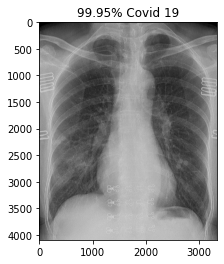

COVID-19\COVID-19 (189).jpg


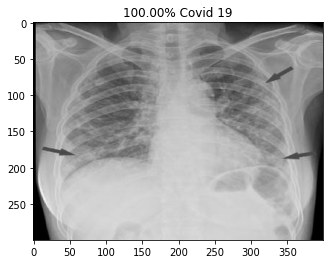

COVID-19\COVID-19 (190).jpg


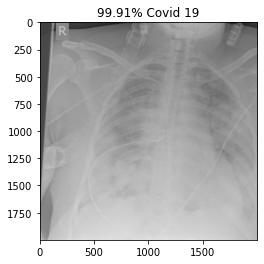

COVID-19\COVID-19 (191).jpg


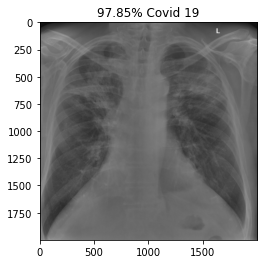

COVID-19\COVID-19 (192).jpg


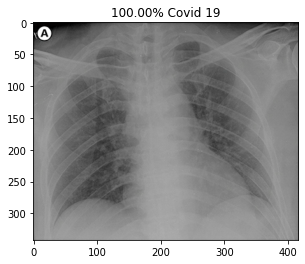

COVID-19\COVID-19 (193).jpg


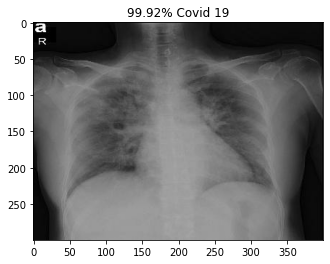

COVID-19\COVID-19 (194).jpg


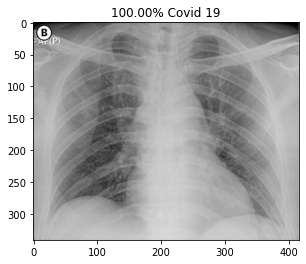

COVID-19\COVID-19 (195).jpg


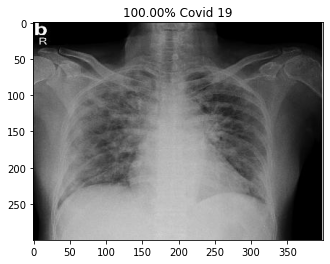

COVID-19\COVID-19 (196).jpg


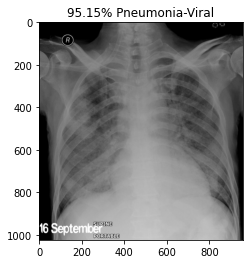

COVID-19\COVID-19 (197).jpg


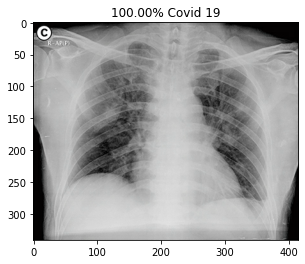

COVID-19\COVID-19 (198).jpg


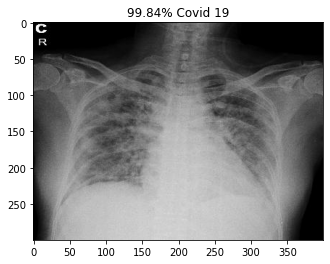

COVID-19\COVID-19 (199).jpg


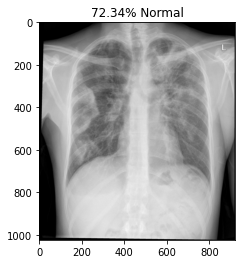

COVID-19\COVID-19 (200).jpg


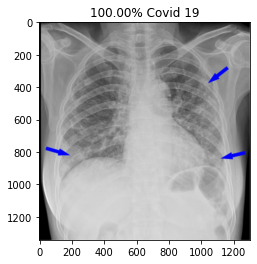

COVID-19\COVID-19 (201).jpg


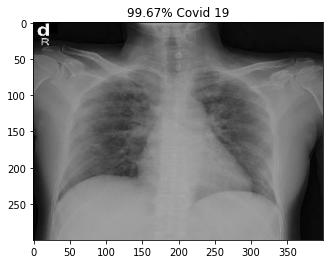

COVID-19\COVID-19 (202).jpg


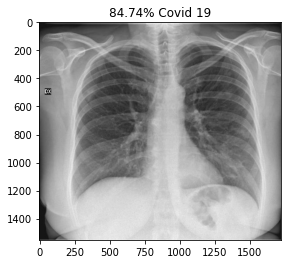

COVID-19\COVID-19 (203).jpg


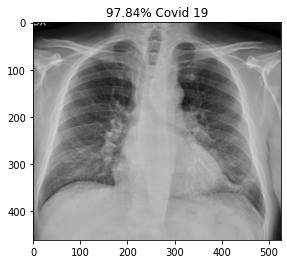

COVID-19\COVID-19 (204).jpg


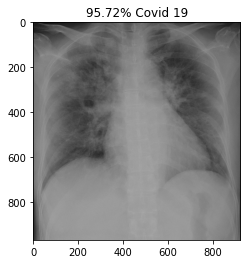

COVID-19\COVID-19 (205).jpg


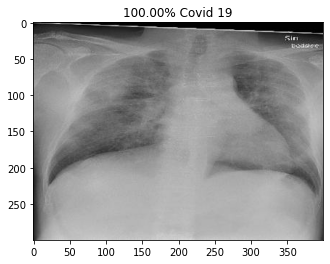

COVID-19\COVID-19 (206).jpg


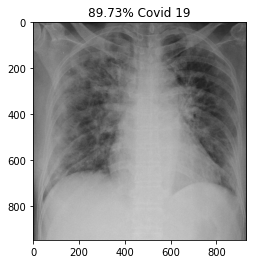

COVID-19\COVID-19 (207).jpg


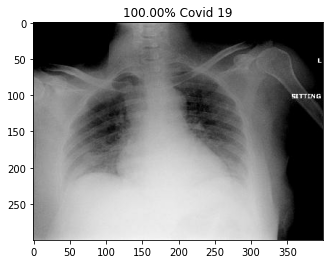

COVID-19\COVID-19 (208).jpg


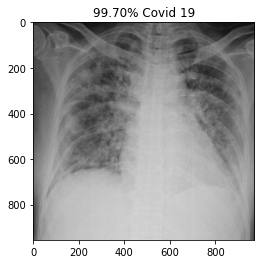

COVID-19\COVID-19 (209).jpg


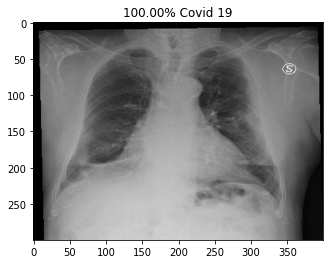

Normal\Normal (460).jpg


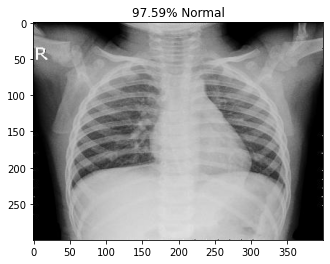

Normal\Normal (462).jpg


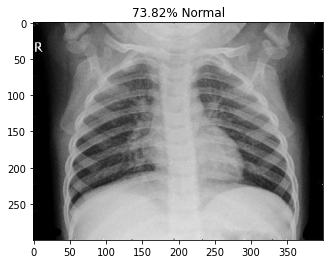

Normal\Normal (463).jpg


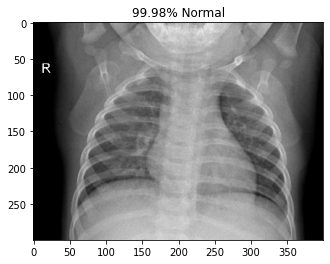

Normal\Normal (464).jpg


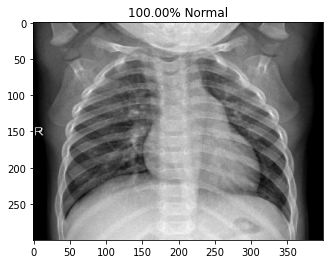

Normal\Normal (474).jpg


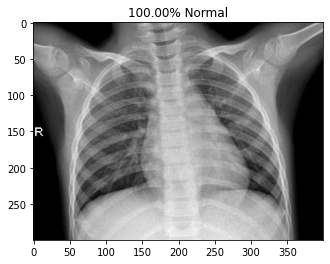

Normal\Normal (475).jpg


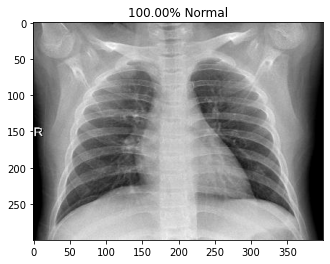

Normal\Normal (478).jpg


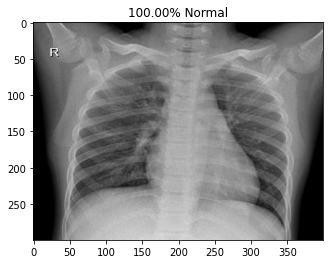

Normal\Normal (481).jpg


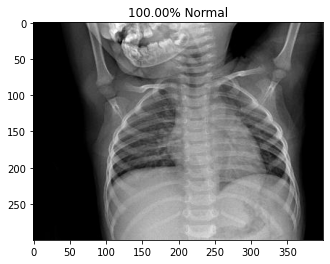

Normal\Normal (483).jpg


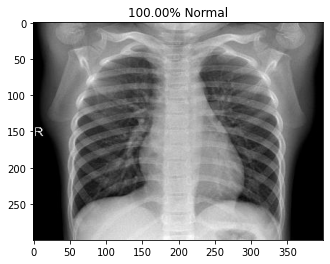

Normal\Normal (485).jpg


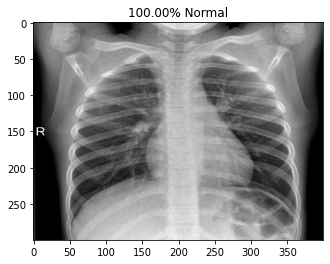

Normal\Normal (493).jpg


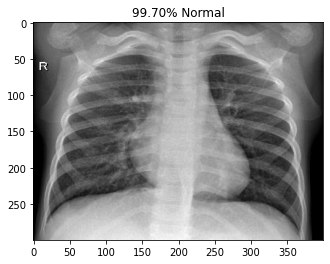

Normal\Normal (495).jpg


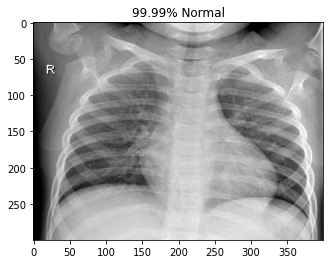

Normal\Normal (498).jpg


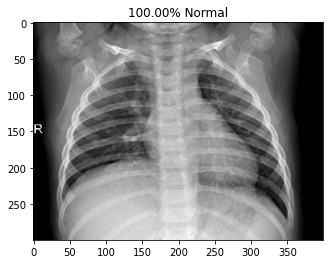

Normal\Normal (499).jpg


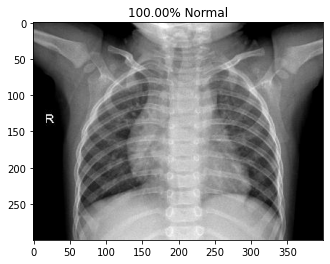

Normal\Normal (500).jpg


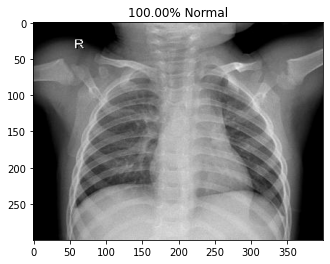

Normal\Normal (501).jpg


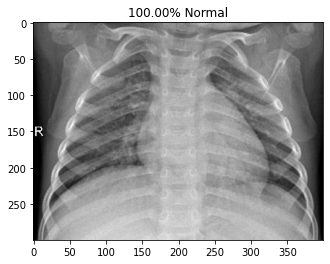

Normal\Normal (503).jpg


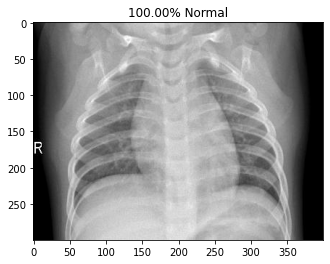

Normal\Normal (507).jpg


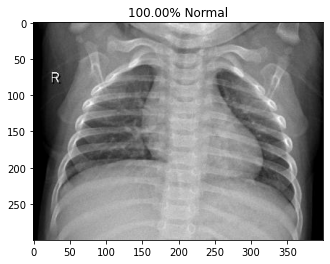

Normal\Normal (512).jpg


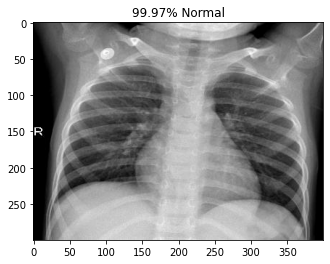

Normal\Normal (514).jpg


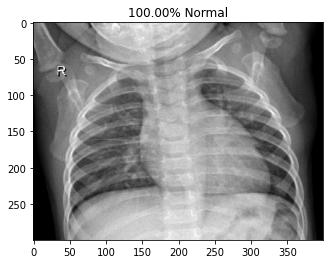

Normal\Normal (518).jpg


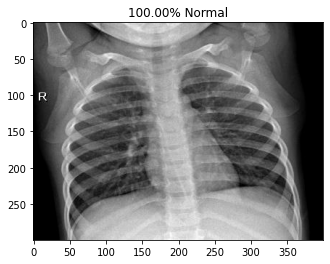

Normal\Normal (521).jpg


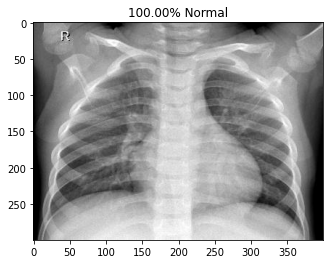

Pneumonia-Viral\Pneumonia-Viral (288).jpg


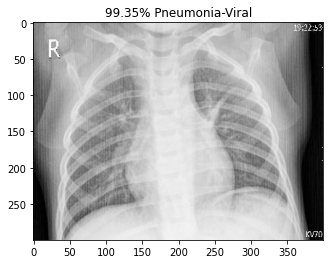

Pneumonia-Viral\Pneumonia-Viral (289).jpg


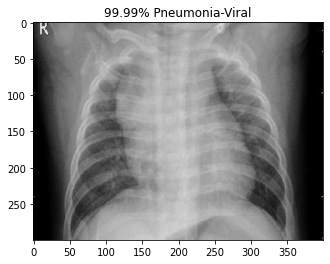

Pneumonia-Viral\Pneumonia-Viral (290).jpg


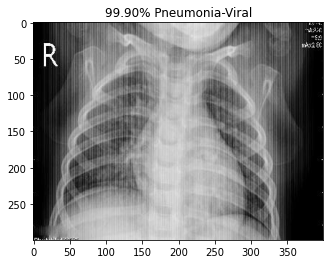

Pneumonia-Viral\Pneumonia-Viral (291).jpg


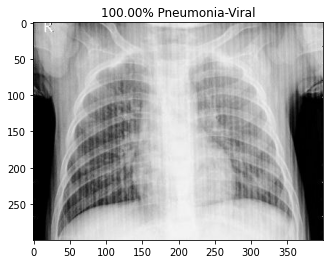

Pneumonia-Viral\Pneumonia-Viral (292).jpg


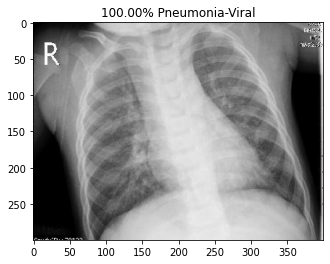

Pneumonia-Viral\Pneumonia-Viral (294).jpg


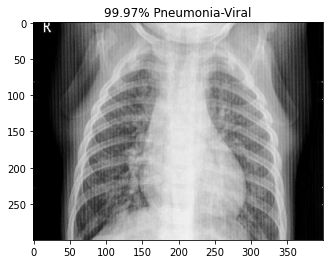

Pneumonia-Viral\Pneumonia-Viral (295).jpg


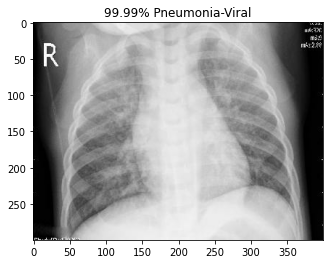

Pneumonia-Viral\Pneumonia-Viral (296).jpg


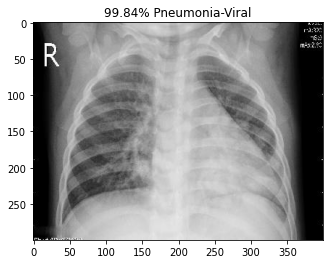

Pneumonia-Viral\Pneumonia-Viral (297).jpg


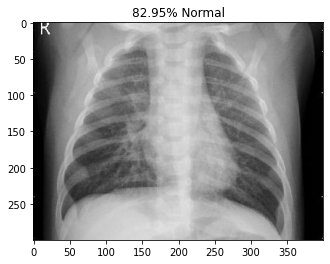

Pneumonia-Viral\Pneumonia-Viral (298).jpg


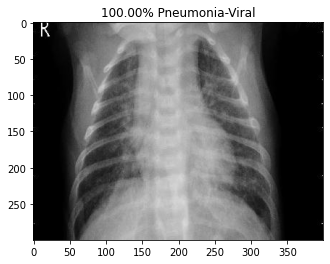

Pneumonia-Viral\Pneumonia-Viral (299).jpg


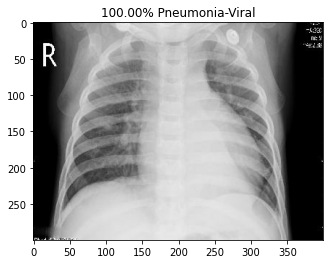

Pneumonia-Viral\Pneumonia-Viral (300).jpg


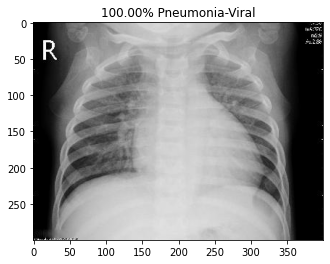

Pneumonia-Viral\Pneumonia-Viral (303).jpg


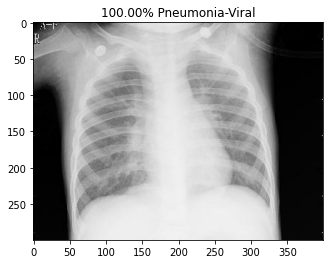

Pneumonia-Viral\Pneumonia-Viral (304).jpg


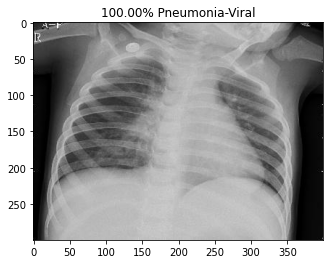

Pneumonia-Viral\Pneumonia-Viral (305).jpg


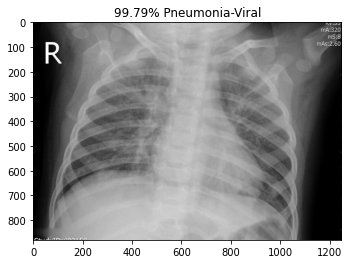

Pneumonia-Viral\Pneumonia-Viral (306).jpg


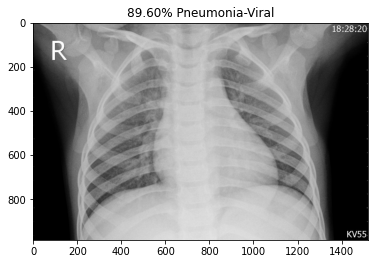

Pneumonia-Viral\Pneumonia-Viral (307).jpg


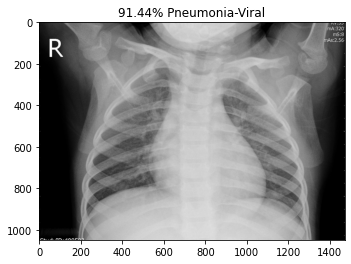

Pneumonia-Viral\Pneumonia-Viral (308).jpg


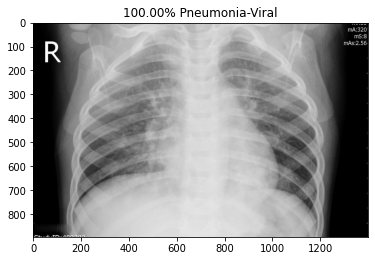

Pneumonia-Viral\Pneumonia-Viral (310).jpg


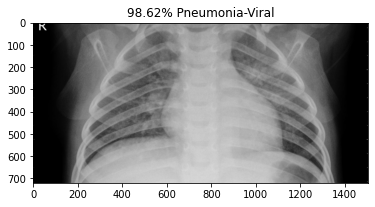

Pneumonia-Viral\Pneumonia-Viral (311).jpg


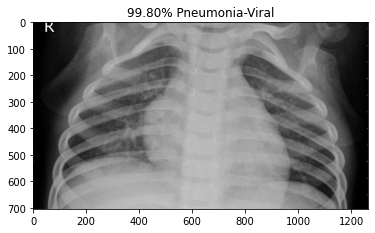

Pneumonia-Viral\Pneumonia-Viral (312).jpg


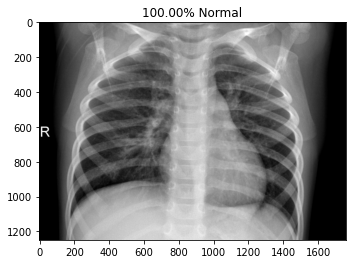

Pneumonia-Viral\Pneumonia-Viral (314).jpg


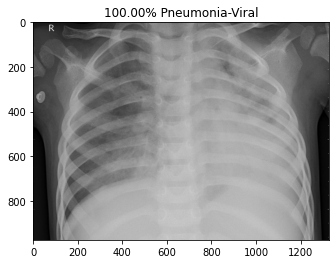

In [20]:
import cv2


import matplotlib.image as mpimg
for index, probability in enumerate(pred):
    image_path = test_dir + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    #BGR TO RGB conversion using CV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    #print(probability)
    if probability[0] > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Covid 19")
    elif probability[1]>0.5 :
        plt.title("%.2f" % ((probability[1])*100) + "% Normal")
    else:
         plt.title("%.2f" % ((probability[2])*100) + "% Pneumonia-Viral")
    plt.show()